In [3]:
# импортируем необходимые модули
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, Binarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sns.set()

In [4]:
# определим, где расположены наши данные
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Описания признаков:
*client_id* - идентификатор клиента

*education* - уровень образования

*sex* - пол заемщика

*age* - возраст заемщика

*car* - флаг наличия автомобиля

*car_type* - флаг автомобиля иномарки

*decline_app_cnt* - количество отказанных прошлых заявок

*good_work* - флаг наличия “хорошей” работы

*bki_request_cnt* - количество запросов в БКИ

*home_address* - категоризатор домашнего адреса

*work_address* - категоризатор рабочего адреса

*income* - доход заемщика

*foreign_passport* - наличие загранпаспорта

*sna* - связь заемщика с клиентами банка

*first_time* - давность наличия информации о заемщике

*score_bki* - скоринговый балл по данным из БКИ

*region_rating* - рейтинг региона

*app_date* - дата подачи заявки

*default* - флаг дефолта по кредиту

In [5]:
RANDOM_SEED = 42

In [6]:
DATA_PATH = "data/"

# загрузим данные
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_test = pd.read_csv(DATA_PATH + "test.csv")

# добавим признак, чтобы было можно определить из какого датасета наблюдение
df_train["is_test"] = False
df_test["is_test"] = True

# т.к. в тестовом датасете нет целевого признака, добавим его и заполним нулями
df_test["default"] = 0

# объединим оба датасета в один для удобства построения графиков и заполнения пропусков
df = pd.concat([df_train, df_test])

In [7]:
# посмотрим на наш датасет
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,is_test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,False
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,False
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,False
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,False
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,False


In [8]:
df.shape

(110148, 20)

Мы видим, что всего в датасета более 110 тысяч наблюдений и без нашего добавленного признака и целевой переменной 18 признаков

In [9]:
# посмотрим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

Датасет содержит 12 признаков в виде чисел и 6 признаков в виде строк. Пропуски содержит только признак education.

In [10]:
# Заполним пропуски самым часто встречающимся значением признака в тренировочной выборке
df["education"].fillna(df[~df["is_test"]]["education"].mode()[0], inplace=True)

In [11]:
# определим, какие признаки являются числовыми, какие - категориальные, и какие - бинарные
df.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
is_test                  2
dtype: int64

In [12]:
# признаки с большим количеством уникальных значений отнесем к числовым, за исключением app_date,
# так как он содержит дату в виде строки. В дальнейшем сделаем преобразование данного признака.
# Также не будем использовать признак client_id, так как все его значения уникальны
num_cols = ["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income", "region_rating"]

# к бинарным отнесем остальные признаки, количество уникальных значений которых равно 2
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# все остальные - категориальные
cat_cols = ["education", "home_address", "work_address", "sna", "first_time"]

In [13]:
# посмотрим уникальные значения признака app_date
df["app_date"].unique()

array(['01FEB2014', '12MAR2014', '23JAN2014', '18APR2014', '18FEB2014',
       '04FEB2014', '17MAR2014', '14FEB2014', '10JAN2014', '03FEB2014',
       '08APR2014', '08JAN2014', '19MAR2014', '22JAN2014', '30JAN2014',
       '11MAR2014', '02FEB2014', '14APR2014', '06JAN2014', '24MAR2014',
       '15APR2014', '28FEB2014', '11FEB2014', '30MAR2014', '23MAR2014',
       '09MAR2014', '02MAR2014', '31JAN2014', '14MAR2014', '26JAN2014',
       '03APR2014', '22MAR2014', '11JAN2014', '17FEB2014', '13FEB2014',
       '17APR2014', '25FEB2014', '10APR2014', '01APR2014', '21APR2014',
       '20MAR2014', '03MAR2014', '25MAR2014', '24FEB2014', '16APR2014',
       '27FEB2014', '18MAR2014', '19FEB2014', '20FEB2014', '31MAR2014',
       '04MAR2014', '25JAN2014', '07JAN2014', '07MAR2014', '26MAR2014',
       '05FEB2014', '06MAR2014', '08FEB2014', '21JAN2014', '13MAR2014',
       '09JAN2014', '07FEB2014', '29JAN2014', '27JAN2014', '15FEB2014',
       '29APR2014', '04APR2014', '16JAN2014', '07APR2014', '13JA

In [14]:
# как мы видим, этот признак в формате ДДМММГГГГ
# извлечем число, месяц и год из признака и преобразуем его в формат datetime
extracted_app_date_df = df["app_date"].str.extract("(\d{2})(\w{3})(\d{4})")
df["app_date"] = extracted_app_date_df.apply(lambda x: datetime.strptime(x[0]+x[1]+x[2], "%d%b%Y"),
                                             axis=1)

In [15]:
# преобразуем значение месяца в числовой формат и добавим новые признаки в наш датафрейм
extracted_app_date_df.columns = ["app_day", "app_month", "app_year"]
extracted_app_date_df["app_month"] = pd.to_datetime(extracted_app_date_df["app_month"],
                                                    format="%b").dt.month
extracted_app_date_df["app_day"] = extracted_app_date_df["app_day"].astype(int)
extracted_app_date_df["app_year"] = extracted_app_date_df["app_year"].astype(
    int)
df = pd.concat([df, extracted_app_date_df], axis=1)
df["app_weekday"] = df["app_date"].dt.weekday

In [16]:
df["app_year"].unique()

array([2014])

In [17]:
# в нашем датасете присутствуют только записи, где год подачи заявки - 2014
# добавим новый признак, обозначающий количество дней прошедших с начала 2014 года
df["app_passed_days"] = (df["app_date"] - datetime(2014, 1, 1)).dt.days

In [18]:
# обновленный датафрейм
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,is_test,app_day,app_month,app_year,app_weekday,app_passed_days
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,4,1,N,0,False,1,2,2014,5,31
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,4,1,N,0,False,12,3,2014,2,70
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,1,4,Y,0,False,1,2,2014,5,31
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,...,1,3,N,0,False,23,1,2014,3,22
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,...,1,4,Y,0,False,18,4,2014,4,107


In [19]:
# распределим новые признаки к числовым переменным
num_cols.extend(["app_day", "app_month", "app_weekday", "app_passed_days"])

Признак app_year не добавили, потому что это константа и он не поможет нам в предсказании целевой переменной. app_date нам также не нужен, так как вся содержащаяся в нем информация уже есть в других признаках

In [20]:
df.drop(["app_date", "app_year"], axis=1, inplace=True)

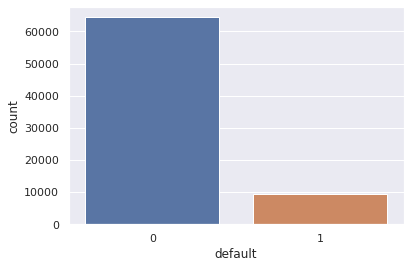

In [21]:
# распределение целевой переменной
sns.countplot(df[~df["is_test"]]["default"]);

### Числовые признаки

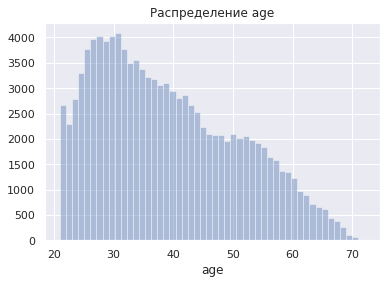

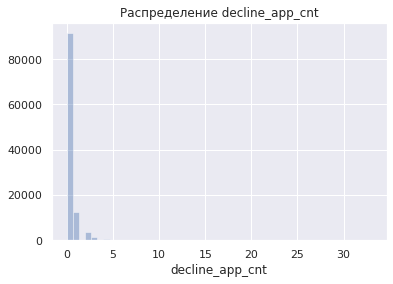

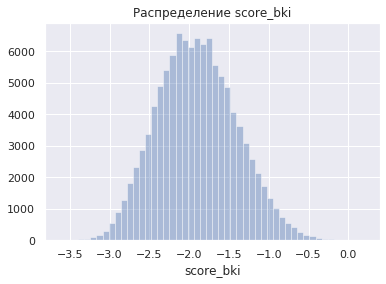

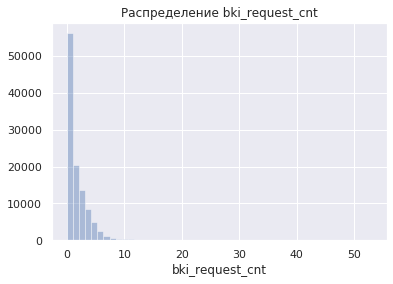

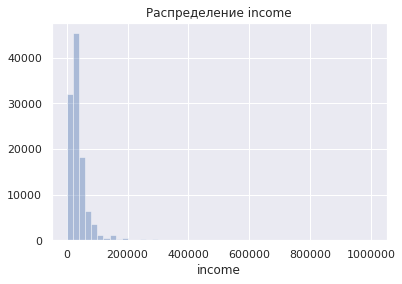

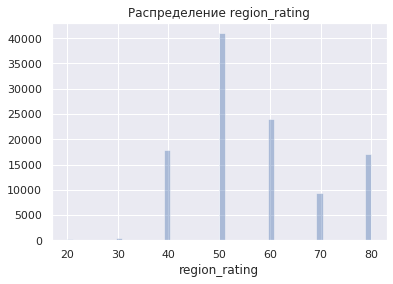

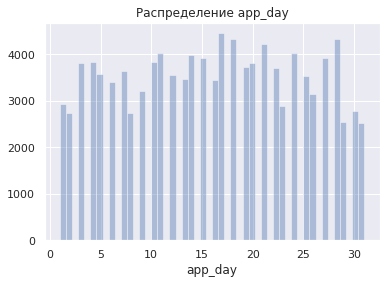

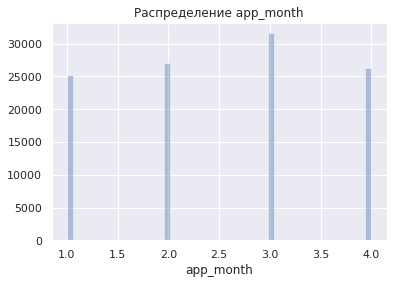

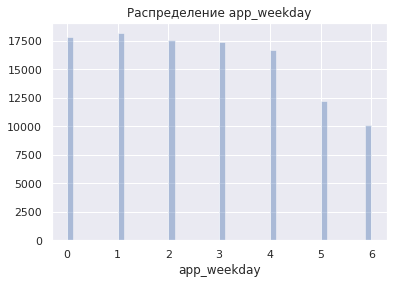

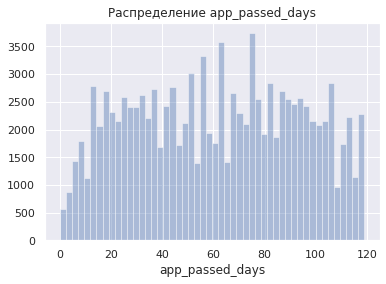

In [22]:
# посмотрим на распределение числовых переменных
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(df[col], kde=False)

In [23]:
df[num_cols].describe()

,age,decline_app_cnt,score_bki,bki_request_cnt,income,region_rating,app_day,app_month,app_weekday,app_passed_days
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,39.249410,0.273205,-1.904535,2.005002,41012.648537,56.751189,15.959100,2.535107,2.674157,60.971466
std,11.518063,0.799099,0.499397,2.266926,45399.735051,13.065923,8.598467,1.087680,1.896814,32.076078
min,21.000000,0.000000,-3.624586,0.000000,1000.000000,20.000000,1.000000,1.000000,0.000000,0.000000
25%,30.000000,0.000000,-2.260434,0.000000,20000.000000,50.000000,9.000000,2.000000,1.000000,33.000000
50%,37.000000,0.000000,-1.920823,1.000000,30000.000000,50.000000,16.000000,3.000000,3.000000,62.000000
75%,48.000000,0.000000,-1.567888,3.000000,48000.000000,60.000000,23.000000,3.000000,4.000000,89.000000
max,72.000000,33.000000,0.199773,53.000000,1000000.000000,80.000000,31.000000,4.000000,6.000000,119.000000


#### Выводы по числовым признакам:
- *age*: график распределения возраста смещен вправо, возраст имеет значения от 21 года до 72 лет и медианой 37 лет
- *decline_app_cnt* (количество отказанных прошлых заявок): распределение также смещено вправо, большинству клиентов (более 75%) раньше не отказывали в кредите, есть небольшое количество клиентов, кому отказывали много раз, максимальный результат - 33 раза. Я не считаю это выброс, т.к. такая ситуация возможна
- *score_bki* (скоринговый балл): признак распределен нормально, но похоже то, что он имеет очень много отрицательных значений это ошибка. Я узнал, что отрицательные значения возможны, но лишь в маленьком количестве случаев
- *bki_request_cnt* (количество запросов в БКИ): распределение признака сильно смещено вправо, более 75% клиентов имеют значение менее 3 запросов, но есть те, у кого количество запросов достигает больших значений. Максимум - 53 запроса. Это также не похоже на нереальный результат.
- *income*: доход клиентов варьируется от 1000 до 1000000 с медианным показателем 30000
- *region_rating*: рейтинг региона варьируется от 20 до 80
- *app_day*, *app_weekday*, *app_month*: принимают значения от 1 до 31, от 0 до 7 и от 1 до 4 соответственно
- *app_passed_days* (количество дней с начала 2014 до даты подачи заявки): в нашем датасете находятся данные только за первые 4 месяца 2014 года, количество заявок по дням примерно равномерное за исключением начала и окончания периода. В начале и конце периода заявок несколько меньше.

In [24]:
# обратим значения скорингового балла
df["score_bki"] = -df["score_bki"]

In [25]:
# признаки, которые имеют ярко выраженное смещение вправо, мы логарифмируем, для того,
# чтобы распределение было больше похоже на нормальное, остальные оставим как есть
skewed_features = ["age", "decline_app_cnt", "bki_request_cnt", "income"]
df[skewed_features] = np.log(df[skewed_features] + 1)

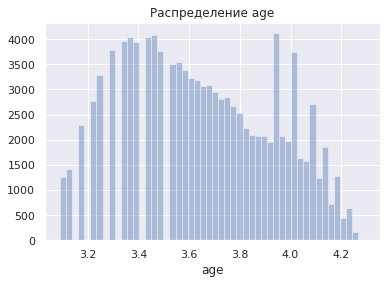

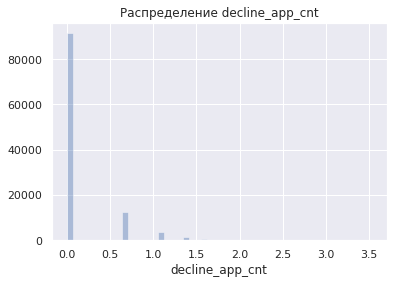

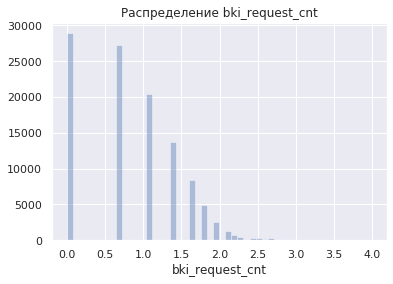

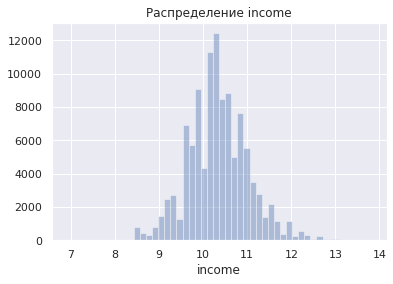

In [26]:
# распределение логарифмированных признаков
for col in skewed_features:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(df[col], kde=False)

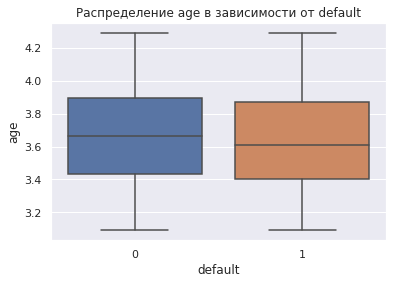

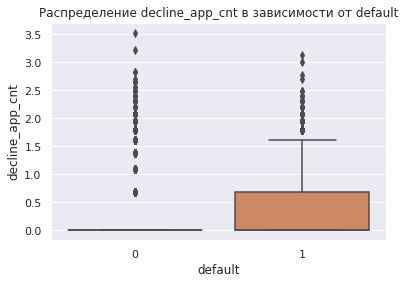

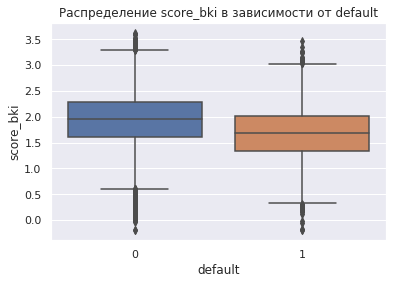

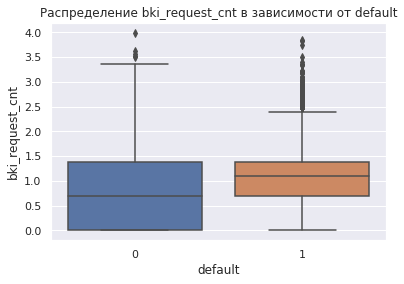

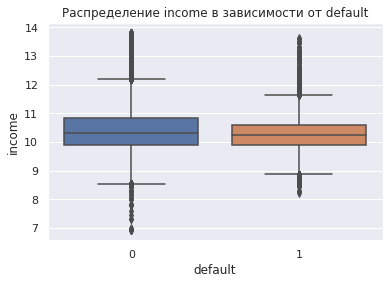

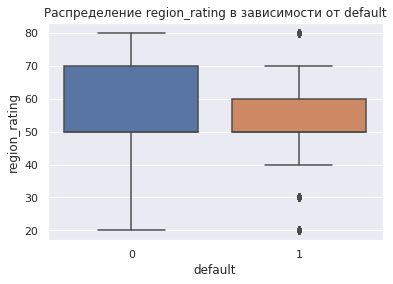

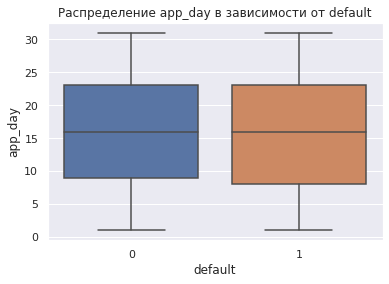

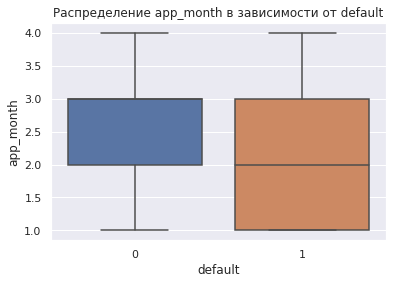

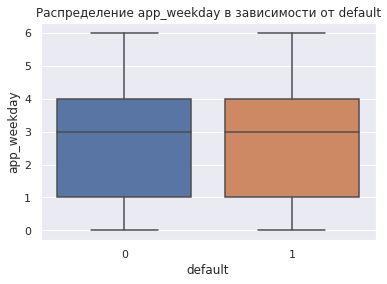

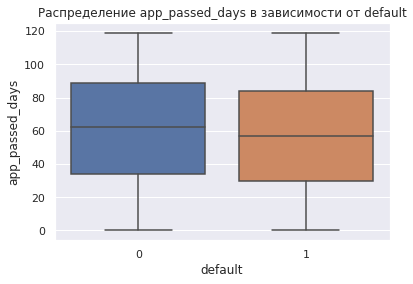

In [27]:
# посмотрим на распределение числовых признаков в зависимости от целевого признака
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col} в зависимости от default")
    sns.boxplot("default", col, data=df[~df["is_test"]])

Судя по графикам, возраст, день подачи заявки и день недели подачи заявки практически не оказывает влияния на вероятность дефолта. Мы позже проверим наше предположение с помощью статистических методов

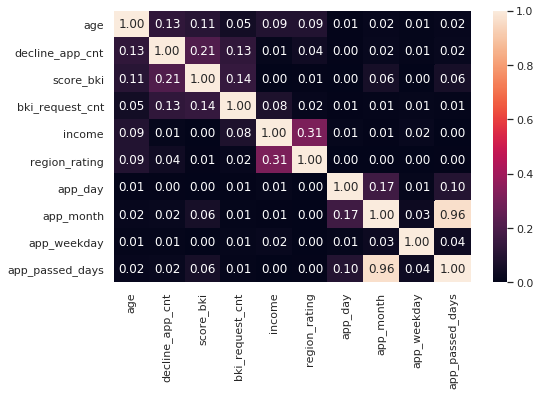

In [28]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Наибольшая корреляция наблюдается между доходом и рейтингом региона, 0.31. Так как значения корреляции небольшие, оставляем все признаки

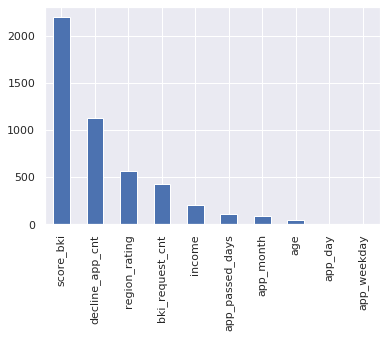

In [29]:
# используем дисперсионный анализ ANOVA для определения значимости наших числовых признаков
imp_num = pd.Series(f_classif(df[num_cols], df["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")

Наибольшее влияние на вероятность дефолта имеет скоринговый балл, очень маленькое влияние - возраст, день подачи заявки и день недели подачи заявки. Удалим эти признаки из модели

In [30]:
num_cols = [col for col in num_cols if col not in [
    "age", "app_day", "app_weekday"]]
df.drop(["age", "app_day", "app_weekday"], axis=1, inplace=True)

### Категориальные и бинарные признаки

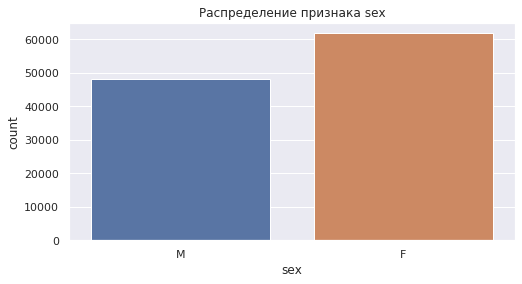

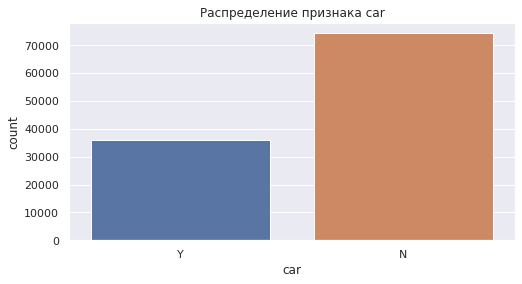

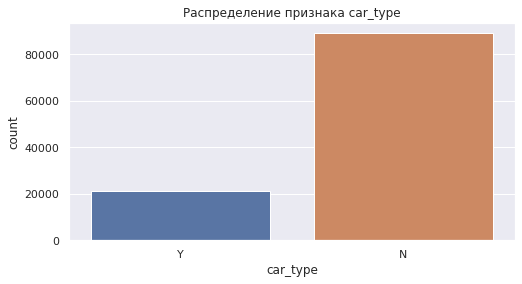

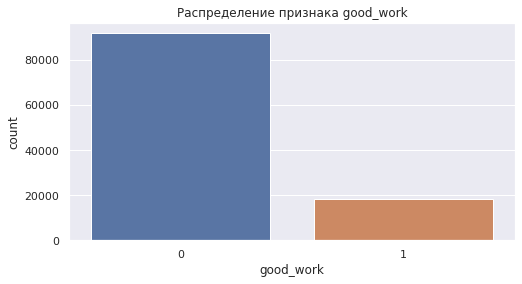

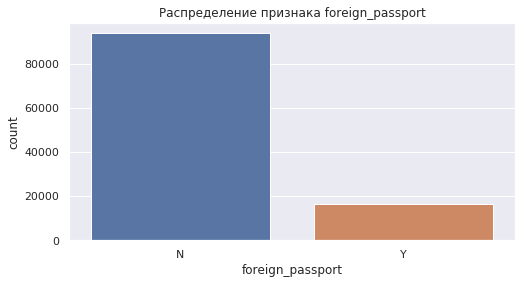

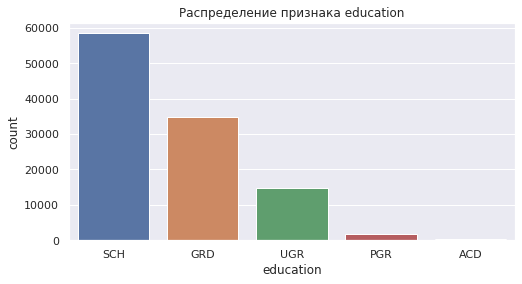

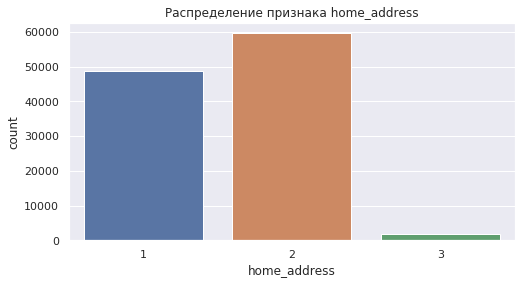

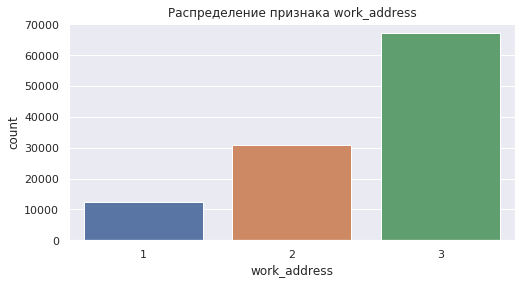

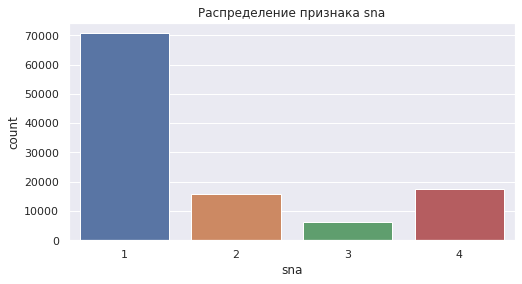

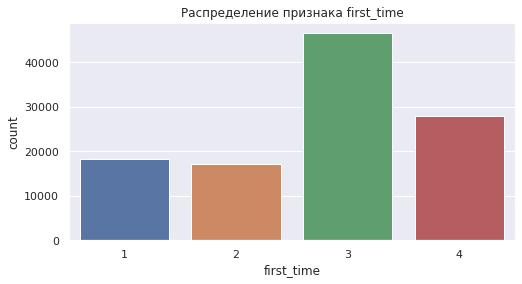

In [31]:
# посмотрим распределение категориальных и бинарных признаков
for col in bin_cols + cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

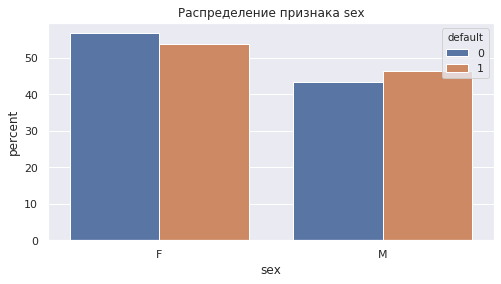

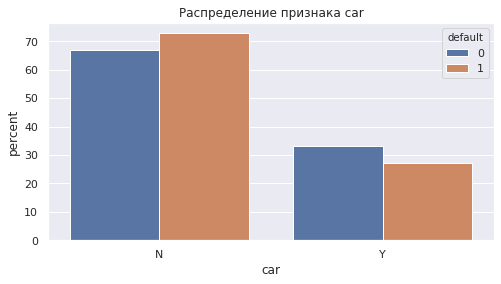

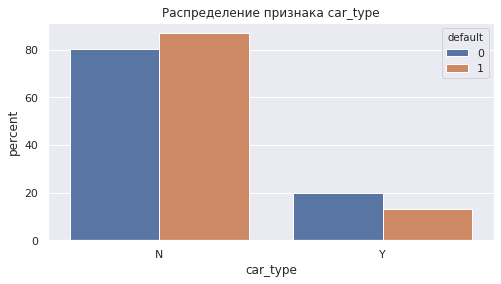

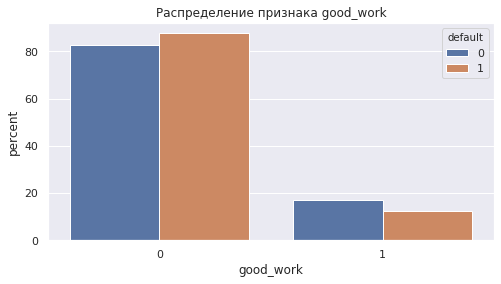

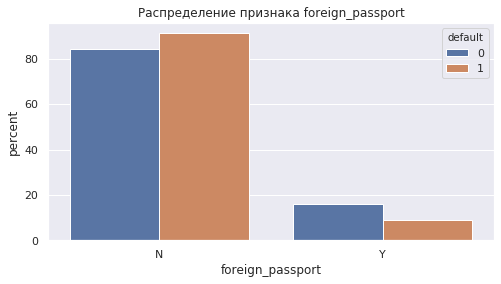

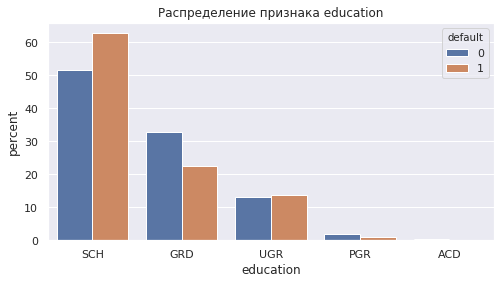

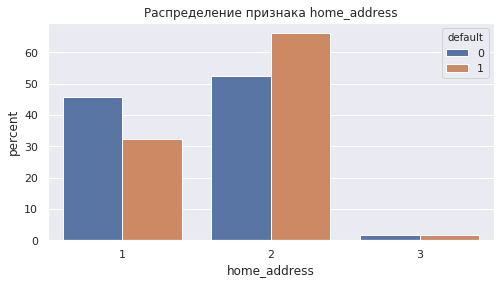

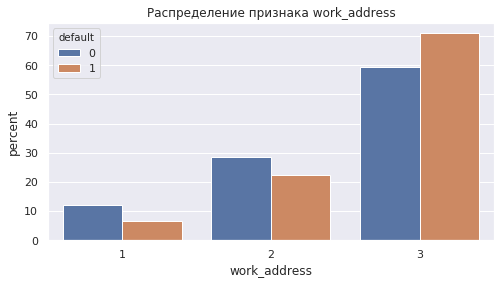

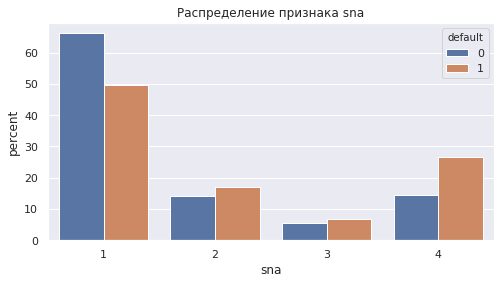

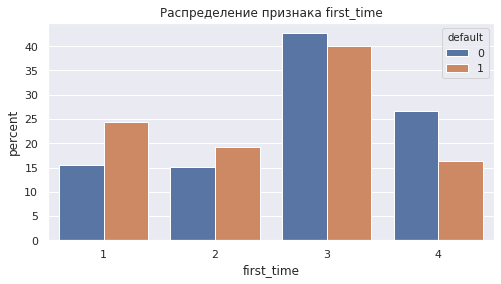

In [32]:
# теперь посмотрим распределение категориальных и бинарных признаков в зависимости от целевого признака
# графики показывают относительное распределение признаков по каждой группе клиентов: "хороших" и "плохих"
data = df[~df["is_test"]]
for col in bin_cols + cat_cols:
    plt.figure(figsize=(8, 4))
    prop_df = data[col].groupby(data["default"]).value_counts(normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

#### Выводы по категориальным признакам:
- *sex*: женщин в выборке немного больше, чем мужчин; женщины более часто отдают кредит, чем мужчины, но разница незначительна
- *car*: клиентов с машиной примерно в 2 раза меньше, чем без машины. Те, у кого есть машина, более кредитоспособны
- *car_type*: клиентов, у которой машина иномарка, еще меньше, и они также более кредитоспособны. Судя по графикам, именно наличие иномарки влияет на кредитоспособность клиента. Чуть позже создадим новый признак, наличие отечественной машины, чтобы проверить предположение
- *good_work*: клиентов с хорошей работой значительно меньше, чем остальных и они более кредитоспособны
- *foreign_passport*: клиентов с загранпаспортом также значительно меньше остальных и они тоже более кредитоспособны
- *education*: чем выше уровень образования у клиента, тем выше вероятность вернуть кредит
- *home_address*: домашние адреса распределены по 3 категориям. Клиенты, проживающие в 1 категории адреса более кредитоспособны, чем во второй и в третьей
- *work_address*: рабочие адреса также распределены по 3 категориям. Клиенты, работающие в 1 и 2 категориях адреса более кредитоспособны, чем работающие в 3 категории
- *sna* (связь заемщика с клиентами банка): чем выше показатель, тем выше риск невозврата кредита
- *first_time* (давность наличия информациии о заемщике): чем выше показатель, тем более благонадежен клиент

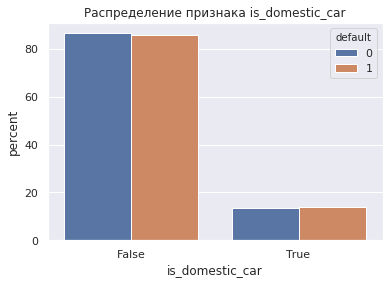

In [33]:
# создадим признак, показывающий наличие отечественной машины и посмотрим, оказывает ли он влияние на вероятность дефолта
df["is_domestic_car"] = (df["car"] == "Y") & (df["car_type"] == "N")

plt.figure()
prop_df = df["is_domestic_car"].groupby(df["default"]).value_counts(
    normalize=True).rename("percent").reset_index()
prop_df["percent"] *= 100
sns.barplot(x="is_domestic_car", y="percent", hue="default", data=prop_df)
plt.title("Распределение признака is_domestic_car")
plt.show()

Да, похоже только наличие иномарки является положительным фактором для принятия решения о выдаче кредита. Так как наличие машины само по себе не влияет на вероятность дефолта, удалим признак car из датасета. Новый признак нам также не нужен, так как он не оказывает никакого влияния на целевую переменную

In [34]:
bin_cols.remove("car")
df.drop(["car", "is_domestic_car"], axis=1, inplace=True)

In [35]:
# чтобы определить значимость категориальных и бинарных признаков для модели, нужно перекодировать их в числа
# перекодируем значения бинарных признаков в 0 или 1
encoded = OrdinalEncoder().fit_transform(df[bin_cols]).astype(np.int8)
df[bin_cols] = pd.DataFrame(encoded, columns=bin_cols)

In [36]:
# образование - это ординальный признак, поэтому нужно перекодировать его значения так,
# чтобы значения возрастали при увеличении уровня образования, от 0 - школа, до 4 - академик
categories = ["SCH", "UGR", "GRD", "PGR", "ACD"]
df["education"] = OrdinalEncoder(categories=[categories]).fit_transform(
    df[["education"]])[:, 0].astype(int)

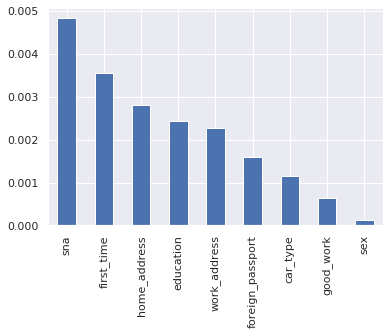

In [37]:
# определим значимость категориальных и бинарных признаков
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df["default"],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True, ascending=False)
imp_cat.plot(kind="bar")

### Подготовка данных к обучению и обучение данных

In [38]:
class Classifier():
    """
    Классификатор, который используя полученные данные, обучает модель, 
    считает различные метрики и строит графики
    """

    def __init__(self, df_train, df_test, *, best_C=None, resampling=False):

        self.best_C = best_C
        self.resampling = resampling

        df_train, df_test = df_train.copy(), df_test.copy()
        df_train["is_test"] = False
        df_test["is_test"] = True

        # т.к. в тестовом датасете нет целевого признака, добавим его и заполним нулями
        df_test["default"] = 0

        # объединим оба датасета в один для удобства обработки данных
        self.data = pd.concat([df_train, df_test])

    def train_model(self, *, features_to_drop=[], verbose=True):
        """
        Обрабатывает данные и обучает модель

        @param resampling: какую технику использовать для resampling'а,
        принимает значения oversampling, undersampling или False
        @param features_to_drop: признаки, которые следует удалить во время предобработки
        @param verbose: нужно ли выводить на экран данные о обучении модели
        """

        self.preprocess_data(features_to_drop)
        self.fit_predict_model(verbose)

    def preprocess_data(self, features_to_drop):
        """
        Обрабатывает данные

        @param features_to_drop: признаки, которые следует удалить из модели
        """

        data = self.data.copy()

        # заменим пропуски признака образование модой
        data["education"].fillna(
            data[~data["is_test"]]["education"].mode()[0], inplace=True)

        # распределим признаки на 4 категории
        num_cols = ["age", "decline_app_cnt", "score_bki",
                    "bki_request_cnt", "income", "region_rating"]
        bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]
        cat_cols = ["home_address", "work_address"]
        ord_cols = ["sna", "first_time"]

        # добавил 4-ую категорию для удобства предобработки данных, ord_cols оставлю как есть,
        # а к cat_cols применю OneHotEncoding, и отдельной обработки требует education

        # извлечем число, месяц и год из признака app_date и преобразуем его в формат datetime
        extracted_app_date_df = data["app_date"].str.extract(
            "(\d{2})(\w{3})(\d{4})")
        data["app_date"] = extracted_app_date_df.apply(lambda x: datetime.strptime(x[0]+x[1]+x[2], "%d%b%Y"),
                                                       axis=1)

        # преобразуем значение месяца в числовой формат и добавим новые признаки в наш датафрейм
        extracted_app_date_df.columns = ["app_day", "app_month", "app_year"]
        extracted_app_date_df["app_month"] = pd.to_datetime(extracted_app_date_df["app_month"],
                                                            format="%b").dt.month
        extracted_app_date_df["app_day"] = extracted_app_date_df["app_day"].astype(
            int)
        extracted_app_date_df["app_year"] = extracted_app_date_df["app_year"].astype(
            int)
        data = pd.concat([data, extracted_app_date_df], axis=1)
        data["app_weekday"] = data["app_date"].dt.weekday

        # добавим новый признак, обозначающий количество дней прошедших с начала 2014 года
        data["app_passed_days"] = (
            data["app_date"] - datetime(2014, 1, 1)).dt.days

        # распределим новые признаки к числовым признакам
        num_cols.extend(
            ["app_day", "app_month", "app_weekday", "app_passed_days"])

        # удалим признак app_year, т.к. он является константой и признак app_date, 
        # т.к. вся информация содержащаяся в нем уже содержат другие признаки
        data.drop(["app_date", "app_year"], axis=1, inplace=True)

        # обратим признак score_bki
        data["score_bki"] = -data["score_bki"]

        # признаки, которые имеют ярко выраженное смещение вправо, мы логарифмируем, для того,
        # чтобы распределение было больше похоже на нормальное, остальные оставим как есть
        skewed_features = ["age", "decline_app_cnt",
                           "bki_request_cnt", "income"]
        data[skewed_features] = np.log(data[skewed_features] + 1)

        # закодируем бинарные признаки 0 или 1
        encoded = OrdinalEncoder().fit_transform(
            data[bin_cols]).astype(np.int8)
        data[bin_cols] = pd.DataFrame(encoded, columns=bin_cols)

        # закодируем признак образование числами от 0 - школа до 4 - академик
        categories = ["SCH", "UGR", "GRD", "PGR", "ACD"]
        data["education"] = OrdinalEncoder(
            categories=[categories]).fit_transform(data[["education"]])[:, 0]

        # применим дамми-кодирование для остальных категориальных признаков
        encoder = OneHotEncoder(sparse=False)
        data_cat = pd.DataFrame(encoder.fit_transform(data[cat_cols]),
                                columns=encoder.get_feature_names(cat_cols))
        data_wo_cat = data.drop(cat_cols, axis=1).reset_index(drop=True)
        data = pd.concat([data_wo_cat, data_cat], axis=1)

        # добавим новые признаки, которые являются комбинациями числовых признаков
        poly = PolynomialFeatures(2, include_bias=False)
        poly_data = poly.fit_transform(data[num_cols])[:, len(num_cols):]
        poly_cols = poly.get_feature_names()[len(num_cols):]
        poly_df = pd.DataFrame(poly_data, columns=poly_cols)
        data = pd.concat([data, poly_df], axis=1)

        # разделим обработанный датасет на изначальные выборки
        data_train = data[~data["is_test"]].drop("is_test", axis=1)
        data_test = data[data["is_test"]].drop("is_test", axis=1)

        # сохраним признаки, которые нужно будет стандартизировать
        self.cols_to_scale = list(
            set(num_cols + poly_cols) - set(features_to_drop))

        # стандартизируем числовые и полиномиальные признаки в тестовой выборке
        # и сохраним обработанную тестовую выборку и id клиентов
        X_final_test = data_test.drop(
            ["default", "client_id"] + features_to_drop, axis=1)
        X_final_test[self.cols_to_scale] = StandardScaler(
        ).fit_transform(X_final_test[self.cols_to_scale])

        self.X_final_test = X_final_test
        self.test_ids = data_test["client_id"]

        # разделим тренировочный датасет на признаки и таргет и сохраним
        self.X = data_train.drop(
            ["default", "client_id"] + features_to_drop, axis=1)
        self.y = data_train["default"]

    def fit_predict_model(self, verbose):
        """
        Находит лучшее значение параметра регуляризации с помощью кросс-валидации и 
        обучает модель с найденным лучшим значением
        """

        # разделим датасет на обучающую и тестовую выборки
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=RANDOM_SEED, stratify=self.y)
        self.y_test = y_test

        # использовал свою функцию для поиска лучшего значения C,
        # т.к. не нашел способа выполнить стандартизацию отдельно 
        # для тренировочных и валидационных данных в LogisticRegressionCV
        # и заодно для улучшения понимания того, как работает кросс-валидация
        if self.best_C is None:
            Cs = np.logspace(-3, 2, 10)
            results = []

            skf = StratifiedKFold(5, shuffle=True, random_state=RANDOM_SEED)

            # для каждого значения C найдем среднее и стандартное отклонение метрики roc auc
            for C in Cs:
                roc_aucs = []

                for train_index, val_index in skf.split(X_train_val, y_train_val):

                    # используя индексы, разделяем датасет на обучающую и валидационную выборки
                    X_train = X_train_val.iloc[train_index].copy()
                    X_val = X_train_val.iloc[val_index].copy()
                    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

                    # стандартизируем числовые и полиномиальные признаки
                    X_train[self.cols_to_scale] = StandardScaler(
                    ).fit_transform(X_train[self.cols_to_scale])
                    X_val[self.cols_to_scale] = StandardScaler(
                    ).fit_transform(X_val[self.cols_to_scale])

                    X_train, y_train = self.resample(X_train, y_train)

                    # обучаем модель с текущим значением C и считаем значение метрики roc auc
                    # на валидационной выборке
                    model = LogisticRegression(C=C, n_jobs=-1, max_iter=1000)
                    model.fit(X_train, y_train)
                    y_pred_proba = model.predict_proba(X_val)

                    roc_auc = metrics.roc_auc_score(y_val, y_pred_proba[:, 1])
                    roc_aucs.append(roc_auc)

                roc_aucs = np.array(roc_aucs)
                result = {
                    "C": C,
                    "roc_auc_mean": round(roc_aucs.mean(), 5),
                    "roc_auc_std": round(roc_aucs.std(), 5)
                }
                if verbose:
                    print(result)

                results.append(result)

            # находим лучшее значение C
            results.sort(key=lambda x: x["roc_auc_mean"], reverse=True)
            self.best_C = results[0]["C"]

        # стандартизируем числовые и полиномиальные признаки
        X_train_val, X_test = X_train_val.copy(), X_test.copy()
        X_train_val[self.cols_to_scale] = StandardScaler(
        ).fit_transform(X_train_val[self.cols_to_scale])
        X_test[self.cols_to_scale] = StandardScaler(
        ).fit_transform(X_test[self.cols_to_scale])
        self.X_test = X_test

        X_train_val, y_train_val = self.resample(X_train_val, y_train_val)

        # обучаем модель с лучшим значением C и предсказываем значения таргета на тестовой выборке
        self.model = LogisticRegression(
            C=self.best_C, n_jobs=-1, max_iter=1000)
        self.model.fit(X_train_val, y_train_val)
        self.y_pred_proba = self.model.predict_proba(X_test)

    def fit_predict_new_data_target(self):
        """Предсказывает вероятности дефолта для новых данных"""

        X, y = self.X.copy(), self.y

        # стандартизируем числовые и полиномиальные признаки
        X[self.cols_to_scale] = StandardScaler(
        ).fit_transform(X[self.cols_to_scale])

        X, y = self.resample(X, y)

        model = LogisticRegression(C=self.best_C, n_jobs=-1, max_iter=1000)
        model.fit(X, y)

        return model.predict_proba(self.X_final_test)

    def resample(self, X, y):
        """Используем resampling для того, чтобы сделать данные более сбалансированными"""

        if self.resampling == "oversampling":
            os = RandomOverSampler(sampling_strategy="minority")
            X, y = os.fit_resample(X, y)
        elif self.resampling == "undersampling":
            us = RandomUnderSampler(sampling_strategy="majority")
            X, y = us.fit_resample(X, y)

        return X, y

    def get_metrics(self, threshold=0.5):
        """
        Считает метрики для модели
        (Оптимальный порог - это такой порог, при котором наибольшая сбалансированная точность)

        @param threshold: порог, значения вероятностей выше которого, принимать за дефолт
        """

        y_pred = Binarizer(threshold=threshold).fit_transform(
            self.y_pred_proba)[:, 1]

        roc_auc = metrics.roc_auc_score(self.y_test, self.y_pred_proba[:, 1])
        c_matrix = metrics.confusion_matrix(self.y_test, y_pred)

        tn, fp, fn, tp = c_matrix.ravel()

        sensitivity = tp / (tp+fn)
        specificity = tn / (tn+fp)
        precision = tp / (tp+fp)

        fprs, tprs, thresholds = metrics.roc_curve(
            self.y_test, self.y_pred_proba[:, 1])

        sensitivities, specificities = tprs, 1 - fprs
        balanced_accuracies = (sensitivities+specificities) / 2

        return {
            "roc_auc": roc_auc,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "precision": precision,
            "f1_score": 2*precision*sensitivity / (precision+sensitivity),
            "balanced_accuracy": (sensitivity+specificity) / 2,
            "optimal_threshold": thresholds[balanced_accuracies.argmax()]
        }

    def show_roc_curve(self):
        """Показывает график ROC"""

        fprs, tprs, _ = metrics.roc_curve(
            self.y_test, self.y_pred_proba[:, 1])

        plt.plot([0, 1], label="Baseline", linestyle="--")
        plt.plot(fprs, tprs, label="Regression")
        plt.title("Receiver operating characteristic", fontsize=15)
        plt.ylabel("True Positive Rate", fontsize=15)
        plt.xlabel("False Positive Rate", fontsize=15)
        plt.legend(loc="lower right")
        plt.show()

    def show_confusion_matrix(self, threshold=0.5):
        """Показывает confusion matrix, используя порог"""

        y_pred = Binarizer(threshold=threshold).fit_transform(
            self.y_pred_proba)[:, 1]

        c_matrix = metrics.confusion_matrix(self.y_test, y_pred)
        c_matrix_df = pd.DataFrame(
            c_matrix, columns=["False", "True"], index=["False", "True"])

        sns.heatmap(c_matrix_df, annot=True, fmt="g",
                    cbar=False, cmap="seismic", linewidths=1)
        plt.xlabel("Predicted default", fontsize=15)
        plt.ylabel("Actual default", fontsize=15)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title(f"Confusion matrix", fontsize=15)
        plt.show()

    def show_balanced_accuracies_curve(self):
        """Показывает график сбалансированной точности в зависимости от порога"""

        fprs, tprs, thresholds = metrics.roc_curve(
            self.y_test, self.y_pred_proba[:, 1])

        sensitivities, specificities = tprs, 1 - fprs
        balanced_accuracies = (sensitivities+specificities) / 2

        plt.title("Balanced Accuracies Curve", fontsize=15)
        plt.xlabel("Threshold", fontsize=15)
        plt.ylabel("Balanced Accuracy", fontsize=15)
        plt.xlim([0, 1])

        plt.plot(thresholds, balanced_accuracies)
        plt.show()

    def show_coeffs(self):
        """Показывает веса модели"""

        feat_names = self.X_test.columns
        coeffs = pd.Series(np.abs(self.model.coef_)[0], feat_names)
        coeffs.sort_values(ascending=False, inplace=True)

        sns.barplot(coeffs, coeffs.index, orient="h")
        plt.show()

    def get_feature_importance(self):
        """Показывает признаки в порядке их значимости для модели"""

        feat_names = self.X_test.columns
        results = permutation_importance(
            self.model, self.X_test, self.y_test, scoring="roc_auc", random_state=RANDOM_SEED)
        importance = results.importances_mean

        feat_imp = pd.Series(importance, feat_names)
        feat_imp.sort_values(ascending=False, inplace=True)

        return feat_imp

    def show_feature_importance(self):
        feat_imp = self.get_feature_importance()
        sns.barplot(feat_imp, feat_imp.index, orient="h")
        plt.show()

In [39]:
def compare_classifiers_metrics(*clfs):
    """Возвращает датафрейм, сравнивающий метрики у разных моделей"""

    if len(clfs) < 2:
        raise TypeError("the function takes 2 or more arguments")

    metrics_ser = [
        pd.Series(clf.get_metrics(), name=f"clf{i+1}") for i, clf in enumerate(clfs)]
    metrics_df = pd.DataFrame(metrics_ser).T

    return metrics_df

In [40]:
# заново загрузим датасеты
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_test = pd.read_csv(DATA_PATH + "test.csv")

In [41]:
# первая модель - baseline модель, которую будем использовать для сравнения с другими
clf1 = Classifier(df_train, df_test)
clf1.train_model()

{'C': 0.001, 'roc_auc_mean': 0.73098, 'roc_auc_std': 0.00683}
{'C': 0.003593813663804626, 'roc_auc_mean': 0.73305, 'roc_auc_std': 0.00708}
{'C': 0.01291549665014884, 'roc_auc_mean': 0.73369, 'roc_auc_std': 0.00728}
{'C': 0.046415888336127795, 'roc_auc_mean': 0.73403, 'roc_auc_std': 0.00745}
{'C': 0.1668100537200059, 'roc_auc_mean': 0.73426, 'roc_auc_std': 0.00757}
{'C': 0.5994842503189409, 'roc_auc_mean': 0.73428, 'roc_auc_std': 0.00762}
{'C': 2.1544346900318843, 'roc_auc_mean': 0.73422, 'roc_auc_std': 0.00764}
{'C': 7.742636826811277, 'roc_auc_mean': 0.73411, 'roc_auc_std': 0.00764}
{'C': 27.825594022071257, 'roc_auc_mean': 0.73403, 'roc_auc_std': 0.00761}
{'C': 100.0, 'roc_auc_mean': 0.73396, 'roc_auc_std': 0.00763}


In [42]:
clf1.get_metrics()

{'roc_auc': 0.736123324958991,
 'sensitivity': 0.028281750266808965,
 'specificity': 0.9948781623467329,
 'precision': 0.44537815126050423,
 'f1_score': 0.05318615153035625,
 'balanced_accuracy': 0.5115799563067709,
 'optimal_threshold': 0.12339810600402291}

Так как наша выборка не сбалансирована, попробуем способы ее сбалансировать

In [43]:
# для начала используем oversampling технику
clf2 = Classifier(df_train, df_test, resampling="oversampling")
clf2.train_model()

{'C': 0.001, 'roc_auc_mean': 0.73292, 'roc_auc_std': 0.00703}
{'C': 0.003593813663804626, 'roc_auc_mean': 0.73333, 'roc_auc_std': 0.00727}
{'C': 0.01291549665014884, 'roc_auc_mean': 0.73375, 'roc_auc_std': 0.0073}
{'C': 0.046415888336127795, 'roc_auc_mean': 0.73392, 'roc_auc_std': 0.00746}
{'C': 0.1668100537200059, 'roc_auc_mean': 0.73384, 'roc_auc_std': 0.0074}
{'C': 0.5994842503189409, 'roc_auc_mean': 0.73349, 'roc_auc_std': 0.00762}
{'C': 2.1544346900318843, 'roc_auc_mean': 0.73376, 'roc_auc_std': 0.0078}
{'C': 7.742636826811277, 'roc_auc_mean': 0.73385, 'roc_auc_std': 0.00769}
{'C': 27.825594022071257, 'roc_auc_mean': 0.73364, 'roc_auc_std': 0.00735}
{'C': 100.0, 'roc_auc_mean': 0.73383, 'roc_auc_std': 0.0074}


In [44]:
clf2.get_metrics()

{'roc_auc': 0.7364134067218797,
 'sensitivity': 0.6787620064034151,
 'specificity': 0.6645972373118113,
 'precision': 0.22738648552020022,
 'f1_score': 0.34065345474022496,
 'balanced_accuracy': 0.6716796218576132,
 'optimal_threshold': 0.5138029423225039}

In [45]:
# затем используем undersampling технику
clf3 = Classifier(df_train, df_test, resampling="undersampling")
clf3.train_model()

{'C': 0.001, 'roc_auc_mean': 0.72881, 'roc_auc_std': 0.00674}
{'C': 0.003593813663804626, 'roc_auc_mean': 0.7311, 'roc_auc_std': 0.0072}
{'C': 0.01291549665014884, 'roc_auc_mean': 0.73273, 'roc_auc_std': 0.0066}
{'C': 0.046415888336127795, 'roc_auc_mean': 0.73242, 'roc_auc_std': 0.00706}
{'C': 0.1668100537200059, 'roc_auc_mean': 0.73285, 'roc_auc_std': 0.00774}
{'C': 0.5994842503189409, 'roc_auc_mean': 0.73285, 'roc_auc_std': 0.00755}
{'C': 2.1544346900318843, 'roc_auc_mean': 0.73294, 'roc_auc_std': 0.00721}
{'C': 7.742636826811277, 'roc_auc_mean': 0.7323, 'roc_auc_std': 0.0079}
{'C': 27.825594022071257, 'roc_auc_mean': 0.7319, 'roc_auc_std': 0.00716}
{'C': 100.0, 'roc_auc_mean': 0.73328, 'roc_auc_std': 0.00719}


In [46]:
clf3.get_metrics()

{'roc_auc': 0.7350113655732537,
 'sensitivity': 0.6755602988260405,
 'specificity': 0.6627347508924414,
 'precision': 0.2255880256593015,
 'f1_score': 0.3382313652150682,
 'balanced_accuracy': 0.6691475248592409,
 'optimal_threshold': 0.5173764741111179}

In [47]:
compare_classifiers_metrics(clf1, clf2, clf3)

,clf1,clf2,clf3
roc_auc,0.736123,0.736413,0.735011
sensitivity,0.028282,0.678762,0.675560
specificity,0.994878,0.664597,0.662735
precision,0.445378,0.227386,0.225588
f1_score,0.053186,0.340653,0.338231
balanced_accuracy,0.511580,0.671680,0.669148
optimal_threshold,0.123398,0.513803,0.517376


Лучшей моделью оказалась модель, где мы использовали oversampling. Теперь посмотрим, улучшатся ли метрики, если мы удалим ненужные признаки.

In [49]:
# для начала удалим признаки, которые имели наименьшее влияние на таргет
# во время предварительной обработки
features_to_drop = ["age", "app_day", "app_weekday", "car"]

clf4 = Classifier(df_train, df_test, best_C=clf2.best_C)
clf4.train_model(features_to_drop=features_to_drop)

In [50]:
clf4.get_metrics()

{'roc_auc': 0.736213310350962,
 'sensitivity': 0.026680896478121666,
 'specificity': 0.9953437839515753,
 'precision': 0.45454545454545453,
 'f1_score': 0.05040322580645161,
 'balanced_accuracy': 0.5110123402148485,
 'optimal_threshold': 0.11995536884730751}

Далее найдем минимальный уровень значимости признака, чтобы включить его в модель и оставим только признаки, которые имеют уровень значимости выше данного уровня. Обучим новую модель с выбранными признаками

In [51]:
def find_best_threshold_to_drop_feats(feat_imp, min_, max_, step):
    """
    Находит минимальный уровень значимости для признака, чтобы включить его
    в модель, которому соответствует наибольшее значения roc_auc

    @param feat_imp: значимость признаков для модели (объект Series)
    @param min_: минимальное значение порога
    @param max_: максимальное значения порога
    @param step: шаг изменения порога
    """

    thresholds, roc_aucs = [], []
    for threshold in np.arange(min_, max_+step, step):
        # для каждого порога обучаем модель, считаем метрику roc_auc
        # и сохраняем в списки значения порога и метрики
        features_to_drop = feats[feats < threshold].index.tolist()

        clf = Classifier(df_train, df_test, best_C=clf1.best_C)
        clf.train_model(features_to_drop=features_to_drop)
        roc_auc = clf.get_metrics()["roc_auc"]

        thresholds.append(threshold)
        roc_aucs.append(roc_auc)

    # конвертируем наши списки в массивы numpy для использования метода argmax
    thresholds, roc_aucs = np.array(thresholds), np.array(roc_aucs)
    best_threshold = thresholds[np.argmax(roc_aucs)]

    # строим график
    ax = sns.lineplot(thresholds, roc_aucs)
    ax.set_xlabel("Порог")
    ax.set_ylabel("ROC AUC")
    ax.set_title(f"Лучший порог: {best_threshold:.4f}")
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    plt.show()

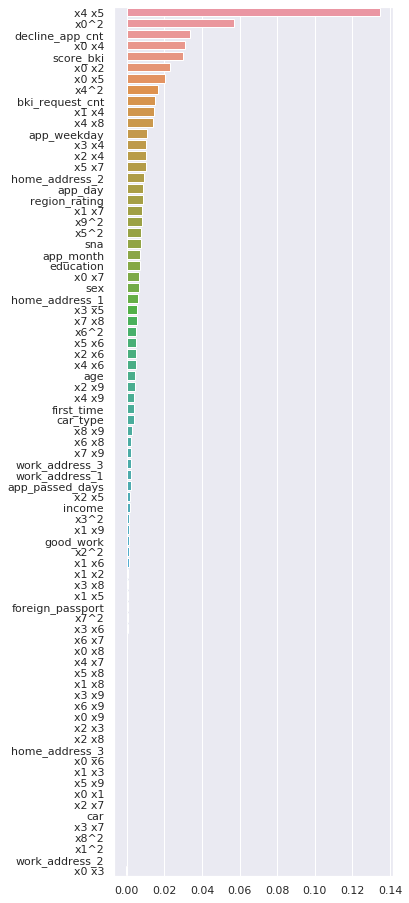

In [52]:
# посмотрим значимость признаков для лучшей модели
plt.figure(figsize=(5, 16))
clf2.show_feature_importance()

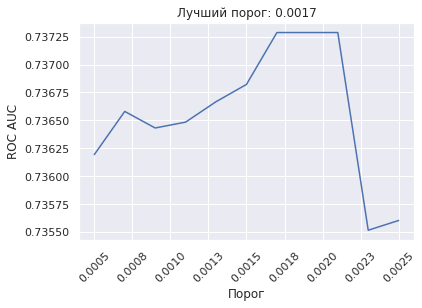

In [53]:
# найдем значение порога для удаления признаков из модели
feats = clf2.get_feature_importance()
find_best_threshold_to_drop_feats(feats, 0.0005, 0.0025, 0.0002)

In [65]:
# удалим признаками ниже определенного уровня значимости
features_to_drop = feats[feats < 0.0017].index.tolist()
features_to_drop

['x2 x5',
 'income',
 'x3^2',
 'x1 x9',
 'good_work',
 'x2^2',
 'x1 x6',
 'x1 x2',
 'x3 x8',
 'x1 x5',
 'foreign_passport',
 'x7^2',
 'x3 x6',
 'x6 x7',
 'x0 x8',
 'x4 x7',
 'x5 x8',
 'x1 x8',
 'x3 x9',
 'x6 x9',
 'x0 x9',
 'x2 x3',
 'x2 x8',
 'home_address_3',
 'x0 x6',
 'x1 x3',
 'x5 x9',
 'x0 x1',
 'x2 x7',
 'car',
 'x3 x7',
 'x8^2',
 'x1^2',
 'work_address_2',
 'x0 x3']

In [66]:
# обучим новую модель с лучшим значением порога
clf5 = Classifier(df_train, df_test, best_C=clf2.best_C)
clf5.train_model(features_to_drop=features_to_drop)

In [67]:
# сравним лучшую модель с двумя вариантами удаления признаков
compare_classifiers_metrics(clf1, clf4, clf5)

,clf1,clf2,clf3
roc_auc,0.736123,0.736213,0.737359
sensitivity,0.028282,0.026681,0.033084
specificity,0.994878,0.995344,0.994025
precision,0.445378,0.454545,0.446043
f1_score,0.053186,0.050403,0.061600
balanced_accuracy,0.511580,0.511012,0.513554
optimal_threshold,0.123398,0.119955,0.114537


Оказалось, что при удалении признаков, которые мы выявили во время предобработки, значения метрик стали немного меньше. А вот при удалении худших признаков согласно показателя значимости признаков уже готовой модели, значения метрик увеличились 

Теперь посмотрим на характеристики выбранной модели

In [68]:
# посмотрим метрики при оптимальном пороге
optimal_threshold = clf5.get_metrics()["optimal_threshold"]
clf5.get_metrics(threshold=optimal_threshold)

{'roc_auc': 0.737359143667041,
 'sensitivity': 0.7273212379935966,
 'specificity': 0.6205959956541983,
 'precision': 0.21801023672424824,
 'f1_score': 0.3354664041348757,
 'balanced_accuracy': 0.6739586168238975,
 'optimal_threshold': 0.11453673697849535}

Чувствительность нашей модели (способность правильно определять плохих заемщиков) - 0.73

Специфичность модели (способность правильно определять хороших заещиков) - 0.62

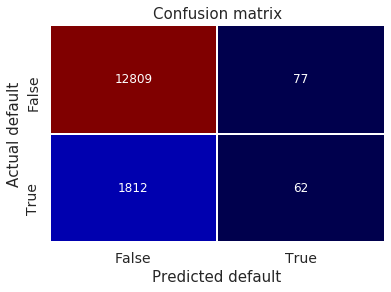

In [69]:
# confusion matrix при стандартном пороге
clf5.show_confusion_matrix()

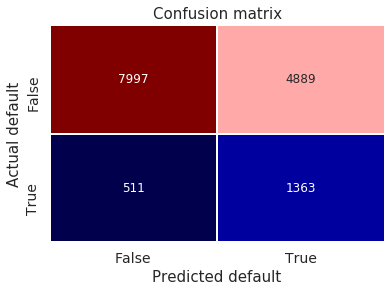

In [70]:
# confusion matrix при оптимальном пороге
clf5.show_confusion_matrix(threshold=optimal_threshold)

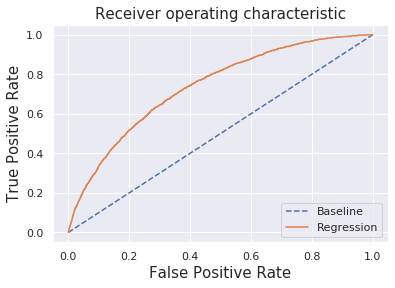

In [71]:
clf5.show_roc_curve()

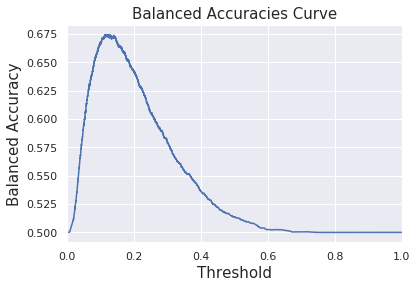

In [72]:
clf5.show_balanced_accuracies_curve()

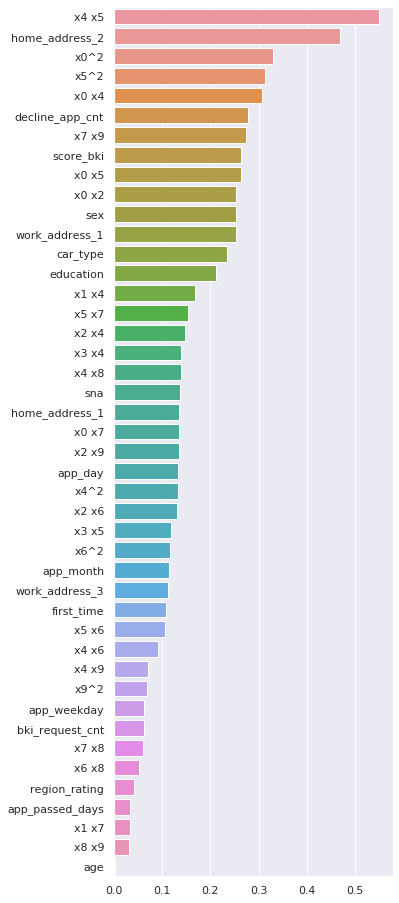

In [73]:
# полученные в результате обучения веса модели
plt.figure(figsize=(5, 16))
clf5.show_coeffs()

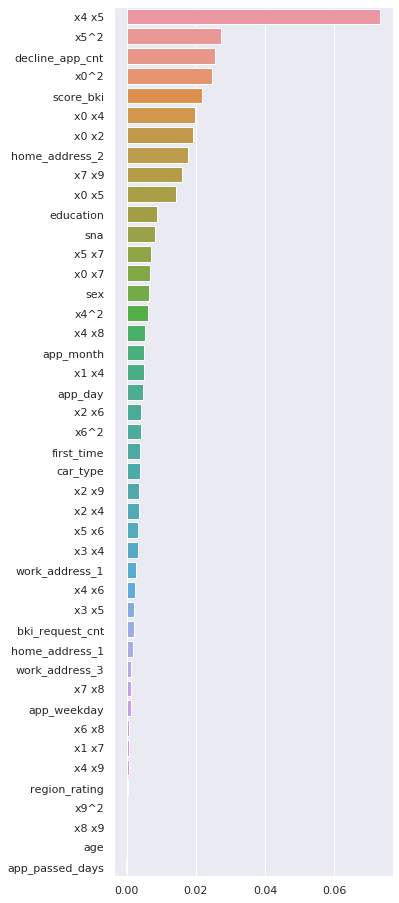

In [74]:
# значимость признаков
plt.figure(figsize=(5, 16))
clf5.show_feature_importance()

В итоге наиболее значимые признаки для модели оказались полиномиальные признаки

In [75]:
# используя выбранную модель, предскажем таргет на отложенной выборке
# и сохраним предсказания в файл для участия в соревновании
y_pred_proba = clf5.fit_predict_new_data_target()[:, 1]

submission = pd.DataFrame(
    {"client_id": clf5.test_ids, "default": y_pred_proba})
submission.to_csv("submission.csv", index=False)
submission.head()

,client_id,default
73799,74835,0.038773
73800,17527,0.342709
73801,75683,0.092912
73802,26883,0.072673
73803,28862,0.028344
